In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
p1_dir = "/rds/general/user/ztb25/home/PBMC_datasets/1/GSE194245_RAW/GSM5831574_PD1.counts.txt.gz"

adata = sc.read_text(
    p1_dir,
    delimiter="\t"
)

In [3]:
adata
# barcodes x number of transcripts

AnnData object with n_obs × n_vars = 18526 × 1043

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-") 
#MT- genes indicate mitochondrial genes, not “mitochondrial cells.” We use them to estimate mitochondrial RNA fraction per cel
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

/rds/general/user/ztb25/home/miniforge3/envs/m10/lib/python3.11/site-packages/scanpy/preprocessing/_qc.py:428: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


AnnData object with n_obs × n_vars = 18526 × 1043
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [ ]:
# n_genes_by_counts in .obs is the number of genes with positive counts in a cell, (corresponds to covariate 2: number of genes)
# total_counts is the total number of counts for a cell, this might also be known as library size (covariate 1: count depth), and
# pct_counts_mt is the proportion of total counts for a cell which are mitochondrial (covariate 3: mitochondrial content).



In [6]:
import seaborn as sns

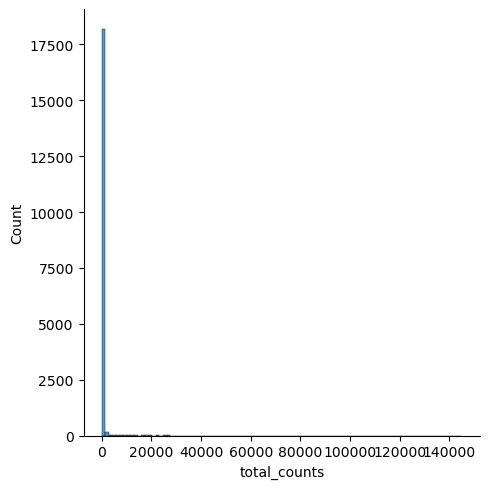

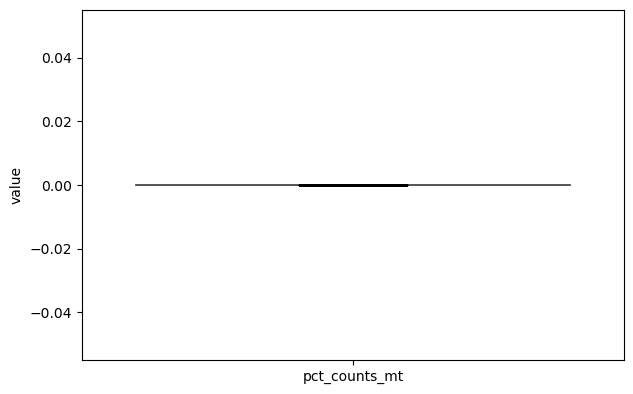

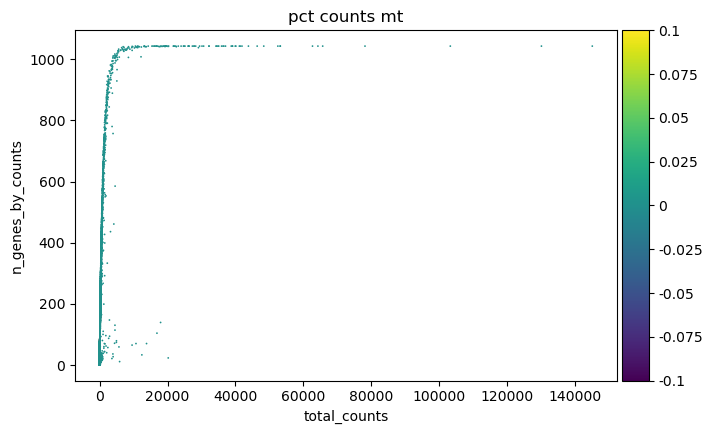

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [9]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    18524
True         2
Name: count, dtype: int64

In [ ]:
# pct_counts_Mt is filtered with 3 MADs. Additionally, cells with a percentage of mitochondrial counts 
# exceeding 8 % are filtered out.

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    18526
Name: count, dtype: int64

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 18526
Number of cells after filtering of low quality cells: 18524


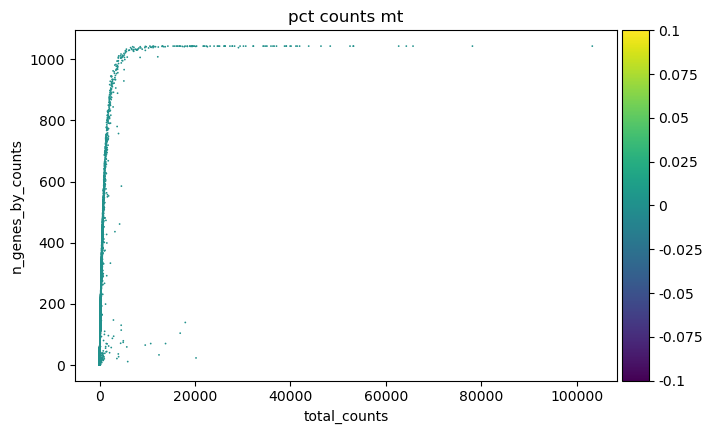

In [12]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [13]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'anndata2ri'